# Nettoyage des donnees avant de les enregistrer en BDD

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import sqlite3
import os

from modules.data_cleaning import apply_zscore, \
                                  category_list_encoding, \
                                  get_volume

raw = '../../datas/RAW/E2/'

# Chargement des csv

In [2]:
dict_csv = {
    'customer':    'olist_customers_dataset.csv',
    'order':       'olist_orders_dataset.csv', 
    'order_items': 'olist_order_items_dataset.csv', 
    'product':     'olist_products_dataset.csv', 
    'seller':      'olist_sellers_dataset.csv',
    'geoloc':      'olist_geolocation_dataset.csv'
}
for csv in dict_csv:
    dict_csv[csv] = (pd.read_csv(raw + dict_csv[csv]))
dict_csv.keys()

dict_keys(['customer', 'order', 'order_items', 'product', 'seller', 'geoloc'])

# Nettoyage des donnees

### Drop na values

sur la table order, j'en profite pour supprimer les 6 commandes annulees (canceled)

In [3]:
for df in dict_csv:
    if dict_csv[df].isna().sum().sum() != 0:
        print('\t' + df.upper())
        print(dict_csv[df].isna().sum())

	ORDER
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
	PRODUCT
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [4]:
order_without_na = dict_csv['order'].dropna()
order_without_na = order_without_na[order_without_na.order_status == 'delivered']
print('Nb de lignes avant et apres traitement')
print(dict_csv['order'].shape)
print(order_without_na.shape)

dict_csv['order'] = order_without_na

Nb de lignes avant et apres traitement
(99441, 8)
(96455, 8)


In [5]:
product_without_na = dict_csv['product'].dropna()
print('Nb de lignes avant et apres traitement')
print(dict_csv['product'].shape)
print(product_without_na.shape)

dict_csv['product'] = product_without_na

Nb de lignes avant et apres traitement
(32951, 9)
(32340, 9)


### Drop outliers

J'applique un zscore uniquement sur la table order_items

In [6]:
dict_csv['order_items'].price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

<AxesSubplot:>

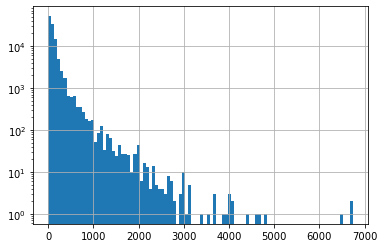

In [7]:
dict_csv['order_items'].price.hist(bins=100, log=True)

(109092, 7)

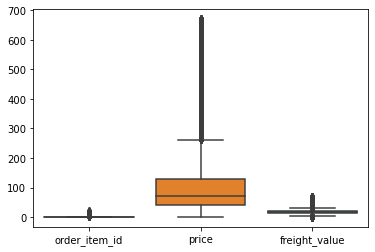

In [8]:
order_items_zscore = apply_zscore(dict_csv['order_items'], ['price', 'freight_value'])
dict_csv['order_items'] = order_items_zscore

ax = sns.boxplot(data=order_items_zscore)
order_items_zscore.shape

# Récuperation des coordonnées

In [10]:
dict_csv['geoloc'] = dict_csv['geoloc'].groupby(['geolocation_zip_code_prefix']).median()
dict_csv['geoloc'].head(1)

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550381,-46.634027


In [11]:
df_geoloc_customer = dict_csv['customer'].merge(dict_csv['geoloc'], how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df_geoloc_customer = df_geoloc_customer[['customer_id', 'geolocation_lat', 'geolocation_lng']]
df_geoloc_customer = df_geoloc_customer.rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng',
})
dict_csv['customer'] = df_geoloc_customer
print(df_geoloc_customer.shape, df_geoloc_customer.columns)
df_geoloc_customer.head(1)

(99441, 3) Index(['customer_id', 'customer_lat', 'customer_lng'], dtype='object')


,customer_id,customer_lat,customer_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,-20.50207,-47.396822


In [16]:
df_geoloc_seller = dict_csv['seller'].merge(dict_csv['geoloc'], how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df_geoloc_seller = df_geoloc_seller[['seller_id', 'geolocation_lat', 'geolocation_lng']]
df_geoloc_seller = df_geoloc_seller.rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng',
})
dict_csv['seller'] = df_geoloc_seller
print(df_geoloc_seller.shape, df_geoloc_seller.columns)
df_geoloc_seller.head(1)

(3095, 3) Index(['seller_id', 'seller_lat', 'seller_lng'], dtype='object')


,seller_id,seller_lat,seller_lng
0,3442f8959a84dea7ee197c632cb2df15,-22.894561,-47.06238


In [28]:
# le ~ inverse la selection du filtre
dict_csv['customer'] = dict_csv['customer'][~ (dict_csv['customer'].isna().any(axis=1))]
dict_csv['seller'] = dict_csv['seller'][~ (dict_csv['seller'].isna().any(axis=1))]

# Jointure des differentes tables

<img src="../documentation/data_schema_essential.png" alt="Schéma des tables du dataset" style="height: 300px;"/>

## Jointure customer et order

In [29]:
df_order_customer = dict_csv['order'].merge(dict_csv['customer'], how='inner', on='customer_id')
df_order_customer = df_order_customer.drop(['customer_id', 'order_delivered_carrier_date', 'order_status'], axis=1)
print(df_order_customer.shape, df_order_customer.columns)
df_order_customer.head(1)

(96191, 7) Index(['order_id', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_lat', 'customer_lng'],
      dtype='object')


,order_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,-23.57617,-46.587276


## Jointure order items et order

In [30]:
print(dict_csv['order_items'].shape)
df_join = dict_csv['order_items'].merge(df_order_customer, how='inner', on='order_id')
df_join = df_join.drop(['shipping_limit_date'], axis=1)
print(df_join.shape)
df_join.head(5)

(109092, 7)
(106472, 12)


,order_id,order_item_id,product_id,seller_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,-21.762829,-41.310605
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,2017-05-15 00:00:00,-20.205737,-50.926924
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,2018-02-05 00:00:00,-19.870383,-44.594355
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,2018-08-20 00:00:00,-23.104346,-46.595589
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,2017-03-17 00:00:00,-23.245512,-46.825182


## Jointure order items et seller

In [31]:
print(df_join.shape)
df_join = df_join.merge(dict_csv['seller'], how='inner', on='seller_id')
df_join = df_join.drop(['seller_id'], axis=1)
print(df_join.shape)
df_join.head(1)

(106472, 12)
(106227, 13)


,order_id,order_item_id,product_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,seller_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,-21.762829,-41.310605,-22.498419,-44.125272


## Jointure order_items et product

1 a plusieurs

In [32]:
df_join = df_join.merge(dict_csv['product'], how='inner', on='product_id')
df_join = df_join.drop(columns=['product_description_lenght', 'product_name_lenght', 'product_photos_qty', 'product_id'])
df_join = df_join.sort_values(by='product_category_name')
df_join.head(1)

,order_id,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
29613,60b4bdf4f0d6dfa53d78a82a4fbd5a6a,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542413,-46.490706,agro_industria_e_comercio,125.0,20.0,4.0,13.0


In [33]:
df_weight = df_join.groupby(by='order_id').product_weight_g.agg(sum)
df_weight = df_weight.reset_index()
df_weight = df_weight.rename(columns={'product_weight_g': 'weight'})

df_join = df_join.drop(columns=['product_weight_g'])
df_join = df_join.merge(df_weight, on='order_id', how='inner')

df_join.head(1)

,order_id,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,seller_lng,product_category_name,product_length_cm,product_height_cm,product_width_cm,weight
0,60b4bdf4f0d6dfa53d78a82a4fbd5a6a,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542413,-46.490706,agro_industria_e_comercio,20.0,4.0,13.0,125.0


In [34]:
df_volume = df_join.groupby(by='order_id')[['product_length_cm', 'product_height_cm', 'product_width_cm']].agg(list)
df_volume = pd.merge(pd.Series(df_volume.index), get_volume(df_volume), left_index=True, right_index=True)

df_join = df_join.drop(columns=['product_length_cm', 'product_height_cm', 'product_width_cm'])
df_join = df_join.merge(df_volume, on='order_id', how='inner')

df_join.head(1)

,order_id,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,seller_lng,product_category_name,weight,volume
0,60b4bdf4f0d6dfa53d78a82a4fbd5a6a,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542413,-46.490706,agro_industria_e_comercio,125.0,1040.0


In [35]:
df_group = df_join.groupby(by='order_id').product_category_name.agg(set).reset_index(name='category')
df_group.category = df_group.category.apply(sorted)
df_group = category_list_encoding(df_group, 'category')

# optimisation de la taille
fcols = df_join.select_dtypes('float').columns
df_join[fcols] = df_join[fcols].apply(pd.to_numeric, downcast='float')

df_join = df_join.merge(df_group, on='order_id', how='inner')
df_join = df_join.drop(columns=['product_category_name', 'order_id'])

df_join.head(1)

,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,...,cds_dvds_musicais,moveis_colchao_e_estofado,tablets_impressao_imagem,construcao_ferramentas_ferramentas,artes_e_artesanato,fashion_esporte,la_cuisine,pc_gamer,seguros_e_servicos,fashion_roupa_infanto_juvenil
0,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Enregistrement en base de donnees

Diminution de la taille memoire

In [36]:
print(df_join.memory_usage().sum())
fcols = df_join.select_dtypes('float').columns
icols = df_join.select_dtypes('integer').columns

df_join[fcols] = df_join[fcols].apply(pd.to_numeric, downcast='float')
df_join[icols] = df_join[icols].apply(pd.to_numeric, downcast='integer')
print(df_join.memory_usage().sum())

69541384
38226815


In [37]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
df_join.to_sql(name='clean_data', con=con, if_exists='replace')
con.close()

### Test de la lecture BDD

In [38]:
con = sqlite3.connect(clean + 'E2.db')
test = pd.read_sql('select * from clean_data LIMIT 3', con, index_col='index')
con.close()
test.head()

,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,...,cds_dvds_musicais,moveis_colchao_e_estofado,tablets_impressao_imagem,construcao_ferramentas_ferramentas,artes_e_artesanato,fashion_esporte,la_cuisine,pc_gamer,seguros_e_servicos,fashion_roupa_infanto_juvenil
index,,,,,,,,,,,,,,,,,,,,,
0,1,21.99,14.110000,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,412.00,27.719999,2018-02-14 16:34:27,2018-02-21 12:28:15,2018-02-28 20:09:19,2018-03-09 00:00:00,-23.114775,-46.553326,-25.437271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,412.00,27.719999,2018-02-14 16:34:27,2018-02-21 12:28:15,2018-02-28 20:09:19,2018-03-09 00:00:00,-23.114775,-46.553326,-25.437271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
